### Import modules

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from tqdm import tqdm
from datetime import datetime
from os.path import exists
from matplotlib.patches import ConnectionPatch
import cmasher as cm
jet_axis = 48

In [2]:
def getNoise(data):
    tmp = np.copy(data)
    tmp[np.abs(tmp) > 3*np.std(tmp)] = 0
    tmp[np.abs(tmp) > 3*np.std(tmp)] = 0
    return np.std(tmp)

    
def getOffset(freq):
    r = -0.01 + 161.37*freq**(-1.16)
    return r

def getX(utc, f):
    """
    We have EVPA measurement of the EVPA calibrator source from NRAO archive for 27-05-2012
    and our reduce VLA observation from 13-01-2014. Hence, for our 2013 observations, we interpolate
    between these two epochs to find the appropriate EVPA of the source. Note that we interpolate in
    time and in wavelenght squared
    
    Parameters
    ----------
    utc     : the UTC of the epoch
    f       : frequnecy 
    
    Returns
    -------
    x       : the predicted EVPA of the calibrator    
    """
    ## arbirary reference time
    refTime = datetime.strptime('2010-01-1', '%Y-%m-%d')
    
    ## define utc for the two epochs for which we have EVPA measurement
    utc1 = (datetime.strptime('2012-05-27', '%Y-%m-%d') - refTime).total_seconds()/(3600*24)
    utc2 = (datetime.strptime('2014-01-13', '%Y-%m-%d') - refTime).total_seconds()/(3600*24)
    
    ## the two bands for which we have measurements
    f1 = 5
    f2 = 8.4
    
    ## values from nrao page
    X1_f1 = -60.635
    X1_f2 = 2.040	

    ## values obtained by me by reducing vla obs
    X2_f1 = -62.63
    X2_f2 = -2.19

    ## step 1) interpolate in time
    utc_float = (utc - refTime).total_seconds()/(3600*24)
    fn_band1 = np.poly1d(np.polyfit([utc1, utc2], [X1_f1, X2_f1], 1))
    fn_band2 = np.poly1d(np.polyfit([utc1, utc2], [X1_f2, X2_f2], 1))
    
    X1_for_utc = fn_band1(utc_float)
    X2_for_utc = fn_band2(utc_float)
    
    ## step 2) interpolate in wavelength squared
    c = 3e8  # Speed of light in m/s
    
    lambda1_squared = (c / (f1*1e9))**2
    lambda2_squared = (c / (f2*1e9))**2
    
    lambda_squared = (c / (f*1e9))**2
    
    fn_lambdaSquared = np.poly1d(np.polyfit([lambda1_squared, lambda2_squared],\
                                            [X1_for_utc, X2_for_utc], 1))
    
    return fn_lambdaSquared(lambda_squared)


### Stack different epochs to make a single rm-synthesis plot

In [3]:
def goodEpoch(epoch, band, IF):
    """
    check
    """
    file1 = exists('/media/steve/NewSSD/papers/cenAVLBA/polAnalysis/EPOCH{}/band{}/CENA-Q-{}.fits'.format(epoch, band, IF))
    file2 = exists('/media/steve/NewSSD/papers/cenAVLBA/polAnalysis/EPOCH{}/band{}/CENA-U-{}.fits'.format(epoch, band, IF))
    file3 = exists('/media/steve/NewSSD/papers/cenAVLBA/polAnalysis/EPOCH{}/band{}/J2202-Q-{}.fits'.format(epoch, band, IF))
    file4 = exists('/media/steve/NewSSD/papers/cenAVLBA/polAnalysis/EPOCH{}/band{}/J2202-U-{}.fits'.format(epoch, band, IF))
        
    if not file1 or not file2 or not file3 or not file4:
        return False
    
    else:
        return True


def getCorrection(epoch, band, IF):
    hduQ = fits.open('/media/steve/NewSSD/papers/cenAVLBA/polAnalysis/EPOCH{}/band{}/J2202-Q-{}.fits'.format(epoch, band, IF))
    hduU = fits.open('/media/steve/NewSSD/papers/cenAVLBA/polAnalysis/EPOCH{}/band{}/J2202-U-{}.fits'.format(epoch, band, IF))
            
    freqQ = hduQ[0].header['CRVAL3']*1e-9
    utcQ = datetime.strptime(hduQ[0].header['DATE-OBS'], '%Y-%m-%d')
        
    dataQ = hduQ[0].data[0,0,:,:]
    dataU = hduU[0].data[0,0,:,:]
            
    ## peak location in lin pol img
    lin_pol = np.sqrt(dataQ**2 + dataU**2)
    max_row, max_col = np.where(lin_pol == np.nanmax(lin_pol))
            
    ## evpa seen in img
    polAngle = np.degrees(1/2*np.arctan2(dataU[max_row, max_col], dataQ[max_row, max_col])) 
            
    ## predicted evpa
    actual_angle = getX(utcQ, freqQ)
            
    ## calculate EVPA correction
    chi_corr = float(actual_angle - polAngle)
    return chi_corr

def multiEpochRMData():
    epoch_list = [1, 2, 3, 4, 5, 6, 12]

    ## define ref freq (used core-shift and rm-synthesis)
    hdu = fits.open('/media/steve/NewSSD/papers/cenAVLBA/polAnalysis/EPOCH12/band11/CENA-Q-8.fits')
    freq0 = float(hdu[0].header['CRVAL3'])/1e9
    imgScale = 0.2 ## mas/pixel

    cena_cube = []
    freq_array = []

    for band in tqdm(range(12)):
        for IF in range(8):
            IF += 1
            local_cube = []
            
            for epoch in epoch_list:

                if not goodEpoch(epoch, band, IF):
                    continue

                hduQ = fits.open('/media/steve/NewSSD/papers/cenAVLBA/polAnalysis/EPOCH{}/band{}/CENA-Q-{}.fits'.format(epoch, band, IF))
                hduU = fits.open('/media/steve/NewSSD/papers/cenAVLBA/polAnalysis/EPOCH{}/band{}/CENA-U-{}.fits'.format(epoch, band, IF))
            
                dataQ_tmp = hduQ[0].data[0,0,:,:]
                dataU_tmp = hduU[0].data[0,0,:,:]

                freqQ = hduQ[0].header['CRVAL3']*1e-9
                freqU = hduU[0].header['CRVAL3']*1e-9

                ## apply core shift
                core_shift = getOffset(freq0)- getOffset(freqQ) 
                core_shift_ra = core_shift*np.sin(np.radians(48))
                core_shift_dec = core_shift*np.cos(np.radians(48))

                dataQ_tmp_1 = np.roll(dataQ_tmp, -int(core_shift_ra/0.2), axis=0)
                dataQ = np.roll(dataQ_tmp_1, int(core_shift_dec/0.2), axis=1)

                dataU_tmp_1 = np.roll(dataU_tmp, -int(core_shift_ra/0.2), axis=0)
                dataU = np.roll(dataU_tmp_1, int(core_shift_dec/0.2), axis=1)

                cen_a_complex = dataQ + 1j*dataU

                evpa_correction = getCorrection(epoch, band, IF)
                
                cen_a_evpa_corrected = cen_a_complex*np.exp(2j*np.radians(evpa_correction))
                local_cube.append(cen_a_evpa_corrected)

            local_cube = np.array(local_cube)
            cen_a_average = np.median(local_cube, axis=0)

            cena_cube.append(cen_a_average)
            freq_array.append(freqQ*1e9)

    return np.array(cena_cube), np.array(freq_array)
    

In [4]:
cena_cube, freq_cube = multiEpochRMData()

  0%|                                                    | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_4139891/1450861760.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_corr = float(actual_angle - polAngle)
100%|███████████████████████████████████████████| 12/12 [01:06<00:00,  5.53s/it]


In [5]:
def getAlpha(epoch, col):
    """
    returns Cen-A spectral index at a given distance downstream
    """
    CenA_sed = np.load('../sed/epoch{}/output_sedMCMC.npy'.format(epoch))
    output_col = np.load('../sed/epoch{}/ouput_colMCMC.npy'.format(epoch))
    
    closestIndex = np.argmin(np.abs(output_col - col))
    
    ## if the closest pixel is more than 3 pixels away, then return nan
    if np.min(np.abs(output_col - col)) > 3:
        return np.nan
    
    else:
        return CenA_sed[closestIndex]
    

def getAverageAlpha(col):
    
    alpha_list = []
    epoch_list = [1, 2, 3, 4, 5, 6, 12]
    
    for epoch in epoch_list:
        alpha = getAlpha(epoch, col)
        alpha_list.append(alpha)
        
    return np.average(alpha_list)

def rmSynth(obs_p_array, num_freq_points, alpha, freq_array, freqNot, bandwidthInWavelenghtSquared, wavelength_squared, threshold=5):
    """
    main function that does rm-synthesis
    """
    
    ### flag IFs with outlier values
    flags = np.ones(num_freq_points)
    q_std = np.std(np.real(obs_p_array))
    q_mu = np.mean(np.real(obs_p_array))
    u_std = np.std(np.imag(obs_p_array))
    u_mu = np.mean(np.imag(obs_p_array))
    
    for i in range(num_freq_points):
        q = np.real(obs_p_array)[i]
        u = np.imag(obs_p_array)[i]
        lambdaSq = wavelength_squared[i]
        angle = np.degrees(1/2*np.arctan2(u, q))
        freq = freq_array[i]
    
        if q >= q_mu + 3*q_std or q<= q_mu - 3*q_std:
            flags[i] = 0
            
        elif u >= u_mu + 3*u_std or u<= u_mu - 3*u_std:
            flags[i] = 0
            
    
    ## do rm synth
    search_phi = np.linspace(-30000, 30000, 1000)  # Adjust the range and number of points as needed
    weight_array = (freq_array/freqNot)**(alpha)*flags

    c = 3e8  # Speed of light in m/s
    rm_synth_output = np.zeros_like(search_phi, dtype=complex)
    K = np.sum(weight_array*bandwidthInWavelenghtSquared)**(-1)
    lambdaNot = (c / freqNot)
    lambdaNotSqured = (c / freqNot)**2
    

    for i, phi_val in enumerate(search_phi):
        val = 0 + 0*1j
        for q, lambdaSquared in enumerate(wavelength_squared):
            val += obs_p_array[q]*np.exp(-2*1j*phi_val*(lambdaSquared - lambdaNot))*bandwidthInWavelenghtSquared[q]
        rm_synth_output[i] = val*K
        
    #plt.plot(search_phi, np.abs(rm_synth_output),  color='black')

    rm_noise = np.std(np.abs(rm_synth_output))
    rm_mu = np.mean(np.abs(rm_synth_output))
    #plt.hlines(5*rm_noise + rm_mu, min(search_phi), max(search_phi), color='black', linestyle='dashed')

    peak_val = search_phi[np.where(abs(rm_synth_output) == np.nanmax(abs(rm_synth_output)))]
    delta_rm = 2*np.sqrt(3)/(max(wavelength_squared) - min(wavelength_squared))
    snr = (max(np.abs(rm_synth_output)) - rm_mu)/rm_noise
    error = delta_rm/(2*snr)
    
    if snr >=threshold:
        return  peak_val, error, np.nanmax(np.abs(rm_synth_output)), snr
    
    else:
        return np.nan, np.nan, np.nan, np.nan


def doStackedRMSynth(cena_cube, freq_cube, threshold):
    """
    does rm-synthesis
    """
    ## define ref freq
    hdu = fits.open('/media/steve/NewSSD/papers/cenAVLBA/polAnalysis/EPOCH12/band11/CENA-Q-8.fits')
    freq0 = float(hdu[0].header['CRVAL3'])/1e9
    
    ## set things up    
    c = 3e8  # Speed of light in m/s
    num_freq_points = len(freq_cube)  # Number of frequency points
    bandwidth_array = np.ones(num_freq_points)*(32000000.0)
    bandwidthInWavelenghtSquared = (c/(freq_cube-bandwidth_array/2) - c/(freq_cube+bandwidth_array/2))**2
    wavelength_squared = (c / freq_cube)**2
    freqNot = np.mean(freq0*1e9)

    ## le magic
    n = 1000
    distances_array = np.linspace(-70, 100, n)
    cena_rm_map = np.zeros((n))
    cena_rm_err_map = np.zeros((n))
    
    x = np.linspace(-(0-512)*0.2, -(1024-512)*0.2, 1024)
    y = np.linspace((0-512)*0.2, (1024-512)*0.2, 1024)

    c = 0 
    for dist in tqdm(distances_array):
        ## convert dist to pixel location
        dist_ra = dist*np.sin(np.radians(jet_axis))
        dist_dec = dist*np.cos(np.radians(jet_axis))

        #row = np.argmin(np.abs(x - dist_ra))
        #col = np.argmin(np.abs(y - dist_dec))

        row = int(512 + dist_ra/0.2)
        col = int(512 - dist_dec/0.2)

        ## get spectral index
        alpha = getAverageAlpha(col)

        ## if no spectral index availabel, continue
        if np.isnan(alpha):
            cena_rm_map[c] = np.nan
            cena_rm_err_map[c] = np.nan
            c += 1
        
            continue

        ## evpa corrected complex intensities
        obs_p_array = cena_cube[:, row, col]
        
        rm, rm_err, polVal, snr = rmSynth(obs_p_array, num_freq_points, alpha,\
            freq_cube, freqNot, bandwidthInWavelenghtSquared, wavelength_squared, threshold)
        cena_rm_map[c] = rm
        cena_rm_err_map[c] = rm_err

        c += 1
    return cena_rm_map, cena_rm_err_map, distances_array


In [6]:
cena_rm_map, cena_rm_err_map, distances_array = doStackedRMSynth(cena_cube, freq_cube, 5)

 18%|███████▏                               | 184/1000 [00:00<00:01, 609.54it/s]/tmp/ipykernel_4139891/1371879070.py:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cena_rm_map[c] = rm
100%|███████████████████████████████████████| 1000/1000 [03:23<00:00,  4.92it/s]


In [7]:
def getFlaggedPol(obs_p_array):

    num_freq_points = len(obs_p_array)
    ### flag IFs with outlier values
    flags = np.ones(num_freq_points)
    q_std = np.std(np.real(obs_p_array))
    q_mu = np.mean(np.real(obs_p_array))
    u_std = np.std(np.imag(obs_p_array))
    u_mu = np.mean(np.imag(obs_p_array))
    
    for i in range(num_freq_points):
        q = np.real(obs_p_array)[i]
        u = np.imag(obs_p_array)[i]
        
        if q >= q_mu + 3*q_std or q<= q_mu - 3*q_std:
            flags[i] = np.nan
            
        elif u >= u_mu + 3*u_std or u<= u_mu - 3*u_std:
            flags[i] = np.nan
            
    return flags

def subplotFunction(ax, dist, rm):
    hfont2 = {'fontname':'Helvetica', 'size':8}

    dist_ra = dist*np.sin(np.radians(jet_axis))
    dist_dec = dist*np.cos(np.radians(jet_axis))

    row = int(512 + dist_ra/0.2)
    col = int(512 - dist_dec/0.2)
    
    angle_array = []
    angle_err_array = []


    for f in range(cena_cube.shape[0]):
    
        real = np.real(cena_cube[f, row, col])
        img = np.imag(cena_cube[f, row, col])
    
        real_noise = np.nanstd(np.real(cena_cube[f, :, :])) + 0.1*real
    
        img_noise = np.nanstd(np.imag(cena_cube[f, :, :])) + 0.1*img
    
    
        yByX_err = abs(img/real)*np.sqrt((img_noise/img)**2 + (real_noise/real)**2)
        PA_std = 1/(1+(img/real)**2)*yByX_err*180/np.pi ### check if this is correct

        angle_err_array.append(PA_std)
        angle_array.append(np.degrees(np.angle(cena_cube[f, row, col])))
    
    
    angle_err_array = np.array(angle_err_array)
    angle_array = np.array(angle_array)

    obs_p_array = cena_cube[:, row, col]
    flags = getFlaggedPol(obs_p_array)

    ax.set_ylim(-180, 180)
    c = 3e8  # Speed of light in m/s

    ax.scatter( (c/freq_cube)**2,  angle_array*flags, alpha=0.2)
    ax.errorbar( (c/freq_cube)**2,  angle_array*flags,yerr=angle_err_array*flags/2, fmt='.', alpha=0.2)


    x_array = (c/freq_cube)**2

    y_array = x_array*rm*180/np.pi

    ax.plot(x_array, y_array, color='black', linestyle='dashed')
    ax.plot(x_array, y_array + 90, color='black', linestyle='dashed')
    ax.plot(x_array, y_array + 180, color='black', linestyle='dashed')
    ax.plot(x_array, y_array + 270, color='black', linestyle='dashed')

    ax.plot(x_array, y_array - 90, color='black', linestyle='dashed')
    ax.plot(x_array, y_array - 180, color='black', linestyle='dashed')
    ax.plot(x_array, y_array - 270, color='black', linestyle='dashed')


    ax.set_xlim(min(x_array), max(x_array))
    ax.set_xlabel(r'$\lambda^{2}$ ($m^2$)', **hfont2)
    ax.set_ylabel(r'$\chi$ (deg)', **hfont2)


    

/tmp/ipykernel_4139891/3085983367.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_subplot = plt.subplot(3, 3, 1, **{'aspect': '0.00001'})
/tmp/ipykernel_4139891/3085983367.py:65: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_subplot = plt.subplot(3, 3, 7, **{'aspect': '0.00001'})
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
fi

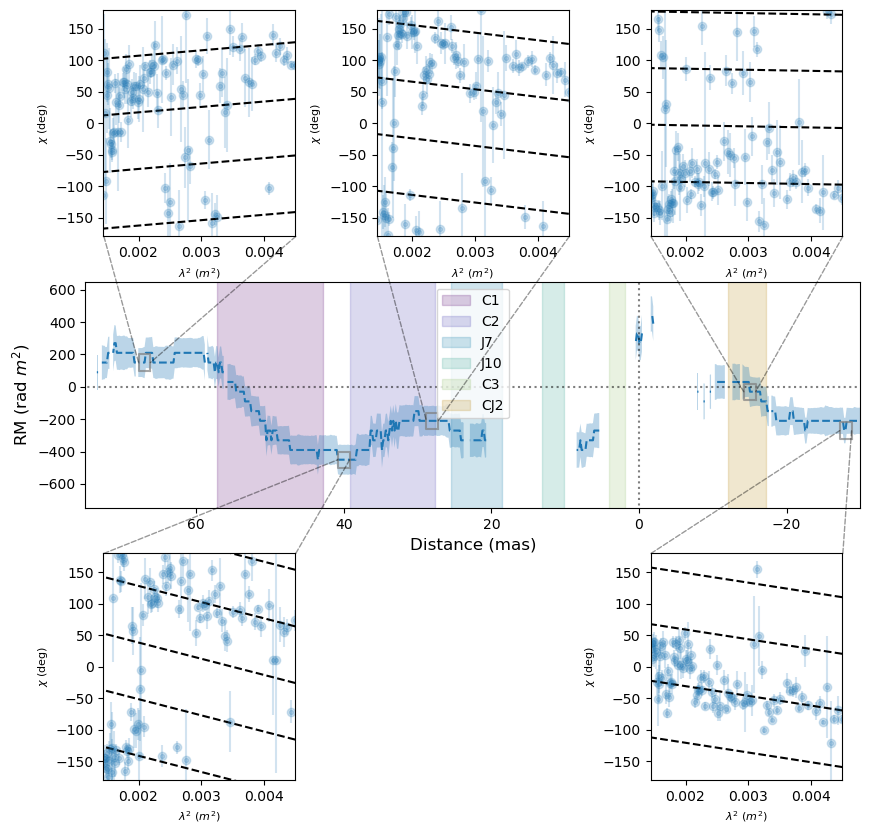

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharex=False)

hfont = {'fontname':'Helvetica', 'size':12}
ax[1].set_xlabel('Distance (mas)', **hfont)
ax[1].set_ylabel(r'RM (rad $m^2$)', **hfont)


ax[1].fill_between(distances_array, cena_rm_map - cena_rm_err_map, cena_rm_map + cena_rm_err_map, alpha=0.3)
ax[1].plot(distances_array, cena_rm_map, linestyle='dashed')
ax[1].hlines(0, 90, -30, color='black', linestyle='dotted', alpha=0.5)
ax[1].vlines(0, -1550, 1550, color='black', linestyle='dotted', alpha=0.5)
ax[1].set_xlim(75, -30)
ax[1].set_ylim(-750, 650)

cmap = cm.cosmic
colors = cm.infinity.colors[::len(cm.infinity.colors)//(6+2)]

ax[1].fill_between([50 - 7.2, 50 + 7.2], -1000, 1000,
                   alpha=0.2, label='C1', zorder=-10, color=colors[0])

ax[1].fill_between([33.4 - 5.7, 33.4 + 5.7], -1000, 1000,
                   alpha=0.2, label='C2', zorder=-10, color=colors[1])

ax[1].fill_between([22 - 3.5, 22 + 3.5], -1000, 1000,
                   alpha=0.2, label='J7', zorder=-10, color=colors[2])

ax[1].fill_between([11.6 - 1.5, 11.6 + 1.5], -1000, 1000,
                   alpha=0.2, label='J10', zorder=-10, color=colors[3])

ax[1].fill_between([3 - 1.1, 3 + 1.1], -1000, 1000,
                   alpha=0.2, label='C3', zorder=-10, color=colors[4])

ax[1].fill_between([-14.6 - 2.6, -14.6 + 2.6], -1000, 1000,
                   alpha=0.2, label='CJ2', zorder=-10, color=colors[5])

ax[1].legend()

####
dist = 67
index = np.argmin(abs(distances_array - dist))
rm = cena_rm_map[index]
ax_subplot = plt.subplot(3, 3, 1, **{'aspect': '0.00001'})
subplotFunction(ax_subplot, dist, rm)
ax[1].plot([dist - 0.8, dist - 0.8, dist + 0.8, dist + 0.8, dist - 0.8],\
           [rm - 50, rm + 50, rm + 50, rm - 50, rm - 50], linestyle='solid', color='grey', alpha=0.7)

con = ConnectionPatch(
            xyA=(0.00145, -180), coordsA=ax_subplot.transData,
            xyB=(dist + 0.8, rm - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)

con = ConnectionPatch(
            xyA=(0.0045, -180), coordsA=ax_subplot.transData,
            xyB=(dist - 0.8, rm - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)



#####
dist = 40
index = np.argmin(abs(distances_array - dist))
rm = cena_rm_map[index]
ax_subplot = plt.subplot(3, 3, 7, **{'aspect': '0.00001'})
subplotFunction(ax_subplot, dist, rm)
ax[1].plot([dist - 0.8, dist - 0.8, dist + 0.8, dist + 0.8, dist - 0.8],\
           [rm - 50, rm + 50, rm + 50, rm - 50, rm - 50], linestyle='solid', color='grey', alpha=0.7)

con = ConnectionPatch(
            xyA=(0.00145, 180), coordsA=ax_subplot.transData,
            xyB=(dist + 0.8, rm - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)

con = ConnectionPatch(
            xyA=(0.0045, 180), coordsA=ax_subplot.transData,
            xyB=(dist - 0.8, rm - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)


#############
dist = 28
index = np.argmin(abs(distances_array - dist))
rm = cena_rm_map[index]
ax_subplot = plt.subplot(3, 3, 2, **{'aspect': '0.00001'})
subplotFunction(ax_subplot, dist, rm)
ax[1].plot([dist - 0.8, dist - 0.8, dist + 0.8, dist + 0.8, dist - 0.8],\
           [rm - 50, rm + 50, rm + 50, rm - 50, rm - 50], linestyle='solid', color='grey', alpha=0.7)

con = ConnectionPatch(
            xyA=(0.00145, -180), coordsA=ax_subplot.transData,
            xyB=(dist + 0.8, rm - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)

con = ConnectionPatch(
            xyA=(0.0045, -180), coordsA=ax_subplot.transData,
            xyB=(dist - 0.8, rm - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)


##############
dist = -15
index = np.argmin(abs(distances_array - dist))
rm = cena_rm_map[index]
ax_subplot = plt.subplot(3, 3, 3, **{'aspect': '0.00001'})
subplotFunction(ax_subplot, dist, rm)
ax[1].plot([dist - 0.8, dist - 0.8, dist + 0.8, dist + 0.8, dist - 0.8],\
           [rm - 50, rm + 50, rm + 50, rm - 50, rm - 50], linestyle='solid', color='grey', alpha=0.7)

con = ConnectionPatch(
            xyA=(0.00145, -180), coordsA=ax_subplot.transData,
            xyB=(dist + 0.8, rm - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)

con = ConnectionPatch(
            xyA=(0.0045, -180), coordsA=ax_subplot.transData,
            xyB=(dist - 0.8, rm - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)


##########
dist = -28
index = np.argmin(abs(distances_array - dist))
rm = cena_rm_map[index]
ax_subplot = plt.subplot(3, 3, 9, **{'aspect': '0.00001'})
subplotFunction(ax_subplot, dist, rm)
ax[1].plot([dist - 0.8, dist - 0.8, dist + 0.8, dist + 0.8, dist - 0.8],\
           [rm - 50, rm + 50, rm + 50, rm - 50, rm - 50], linestyle='solid', color='grey', alpha=0.7)

con = ConnectionPatch(
            xyA=(0.00145, 180), coordsA=ax_subplot.transData,
            xyB=(dist + 0.8, rm - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)

con = ConnectionPatch(
            xyA=(0.0045, 180), coordsA=ax_subplot.transData,
            xyB=(dist - 0.8, rm - 0.3), coordsB=ax[1].transData,
            arrowstyle="-", alpha=0.4, linestyle="dashed")
fig.add_artist(con)


plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.savefig('rm-results.png', dpi=300)

### do plot RM plot epoch wise

In [9]:
def epochRMData(epoch):
    epoch_list = [epoch]

    ## define ref freq (used core-shift and rm-synthesis)
    hdu = fits.open('/media/steve/NewSSD/papers/cenAVLBA/polAnalysis/EPOCH12/band11/CENA-Q-8.fits')
    freq0 = float(hdu[0].header['CRVAL3'])/1e9
    imgScale = 0.2 ## mas/pixel

    cena_cube = []
    freq_array = []

    for band in tqdm(range(12)):
        for IF in range(8):
            IF += 1
            local_cube = []
            
            for epoch in epoch_list:

                if not goodEpoch(epoch, band, IF):
                    continue

                hduQ = fits.open('/media/steve/NewSSD/papers/cenAVLBA/polAnalysis/EPOCH{}/band{}/CENA-Q-{}.fits'.format(epoch, band, IF))
                hduU = fits.open('/media/steve/NewSSD/papers/cenAVLBA/polAnalysis/EPOCH{}/band{}/CENA-U-{}.fits'.format(epoch, band, IF))
            
                dataQ_tmp = hduQ[0].data[0,0,:,:]
                dataU_tmp = hduU[0].data[0,0,:,:]

                freqQ = hduQ[0].header['CRVAL3']*1e-9
                freqU = hduU[0].header['CRVAL3']*1e-9

                ## apply core shift
                core_shift = getOffset(freq0)- getOffset(freqQ) 
                core_shift_ra = core_shift*np.sin(np.radians(48))
                core_shift_dec = core_shift*np.cos(np.radians(48))

                dataQ_tmp_1 = np.roll(dataQ_tmp, -int(core_shift_ra/0.2), axis=0)
                dataQ = np.roll(dataQ_tmp_1, int(core_shift_dec/0.2), axis=1)

                dataU_tmp_1 = np.roll(dataU_tmp, -int(core_shift_ra/0.2), axis=0)
                dataU = np.roll(dataU_tmp_1, int(core_shift_dec/0.2), axis=1)

                cen_a_complex = dataQ + 1j*dataU

                evpa_correction = getCorrection(epoch, band, IF)
                
                cen_a_evpa_corrected = cen_a_complex*np.exp(2j*np.radians(evpa_correction))
                #local_cube = cen_a_evpa_corrected

            #local_cube = np.array(local_cube)
            #cen_a_average = np.median(local_cube, axis=0)

            cena_cube.append(cen_a_evpa_corrected)
            freq_array.append(freqQ*1e9)

    return np.array(cena_cube), np.array(freq_array)
    

In [10]:
epoch = 1
cena_cube1, freq_cube1 = epochRMData(epoch)
cena_rm_map1, cena_rm_err_map1, distances_array1 = doStackedRMSynth(cena_cube1, freq_cube1, 5)

epoch = 2
cena_cube2, freq_cube2 = epochRMData(epoch)
cena_rm_map2, cena_rm_err_map2, distances_array2 = doStackedRMSynth(cena_cube2, freq_cube2, 5)

epoch = 3
cena_cube3, freq_cube3 = epochRMData(epoch)
cena_rm_map3, cena_rm_err_map3, distances_array3 = doStackedRMSynth(cena_cube3, freq_cube3, 5)

epoch = 4
cena_cube4, freq_cube4 = epochRMData(epoch)
cena_rm_map4, cena_rm_err_map4, distances_array4 = doStackedRMSynth(cena_cube4, freq_cube4, 5)

epoch = 5
cena_cube5, freq_cube5 = epochRMData(epoch)
cena_rm_map5, cena_rm_err_map5, distances_array5 = doStackedRMSynth(cena_cube5, freq_cube5, 5)


epoch = 6
cena_cube6, freq_cube6 = epochRMData(epoch)
cena_rm_map6, cena_rm_err_map6, distances_array6 = doStackedRMSynth(cena_cube6, freq_cube6, 5)

epoch = 12
cena_cube12, freq_cube12 = epochRMData(epoch)
cena_rm_map12, cena_rm_err_map12, distances_array12 = doStackedRMSynth(cena_cube12, freq_cube12, 5)


  0%|                                                                                                                                                                                | 0/12 [00:00<?, ?it/s]/tmp/ipykernel_3826085/1450861760.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  chi_corr = float(actual_angle - polAngle)
 17%|███████████████████████████▍                                                                                                                                       | 168/1000 [00:00<00:01, 821.81it/s]/tmp/ipykernel_3826085/1371879070.py:143: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cena_rm_map[c] = rm
1

(-750.0, 650.0)

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


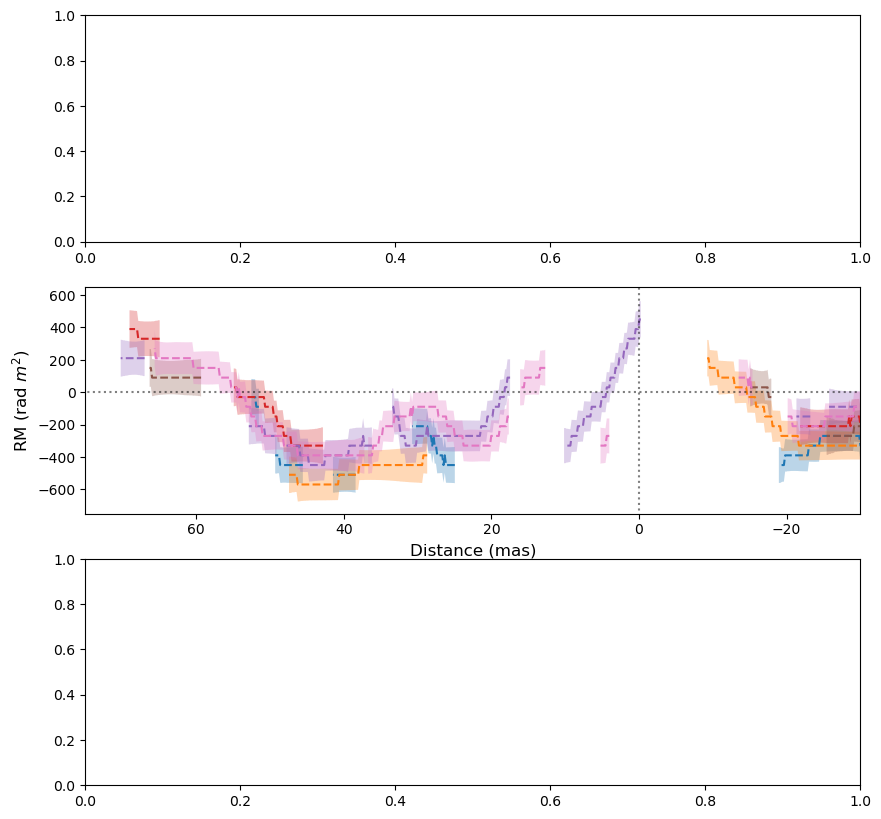

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,10), sharex=False)

hfont = {'fontname':'Helvetica', 'size':12}
ax[1].set_xlabel('Distance (mas)', **hfont)
ax[1].set_ylabel(r'RM (rad $m^2$)', **hfont)


ax[1].fill_between(distances_array1, cena_rm_map1 - cena_rm_err_map1, cena_rm_map1 + cena_rm_err_map1, alpha=0.3)
ax[1].plot(distances_array1, cena_rm_map1, linestyle='dashed')

ax[1].fill_between(distances_array2, cena_rm_map2 - cena_rm_err_map2, cena_rm_map2 + cena_rm_err_map2, alpha=0.3)
ax[1].plot(distances_array2, cena_rm_map2, linestyle='dashed')

ax[1].fill_between(distances_array3, cena_rm_map3 - cena_rm_err_map3, cena_rm_map3 + cena_rm_err_map3, alpha=0.3)
ax[1].plot(distances_array3, cena_rm_map3, linestyle='dashed')


ax[1].fill_between(distances_array4, cena_rm_map4 - cena_rm_err_map4, cena_rm_map4 + cena_rm_err_map4, alpha=0.3)
ax[1].plot(distances_array4, cena_rm_map4, linestyle='dashed')


ax[1].fill_between(distances_array5, cena_rm_map5 - cena_rm_err_map5, cena_rm_map5 + cena_rm_err_map5, alpha=0.3)
ax[1].plot(distances_array5, cena_rm_map5, linestyle='dashed')

ax[1].fill_between(distances_array6, cena_rm_map6 - cena_rm_err_map6, cena_rm_map6 + cena_rm_err_map6, alpha=0.3)
ax[1].plot(distances_array6, cena_rm_map6, linestyle='dashed')

ax[1].fill_between(distances_array12, cena_rm_map12 - cena_rm_err_map12, cena_rm_map12 + cena_rm_err_map12, alpha=0.3)
ax[1].plot(distances_array12, cena_rm_map12, linestyle='dashed')


ax[1].hlines(0, 90, -30, color='black', linestyle='dotted', alpha=0.5)
ax[1].vlines(0, -1550, 1550, color='black', linestyle='dotted', alpha=0.5)
ax[1].set_xlim(75, -30)
ax[1].set_ylim(-750, 650)
